In [1]:
import torch
from seta import (
    MLPThinker,
    System,
    Dynamics,
    Simulator,
    CustomFunctionDataset, OfflineRBFInterpolationDataset,
    Environment,
    Trainer)

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


In [2]:
# params

T_max= 100
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# DATASET
import pickle
import numpy as np

# Load the RBF interpolation from the file
with open('rbf_interpolation_internodes.pkl', 'rb') as f:
    rbf_loaded = pickle.load(f)


def curve_data(time_tensor: torch.Tensor, temperature: float) -> torch.Tensor:
    pred = []
    for el in time_tensor:
        pred.append(torch.tensor(rbf_loaded(np.array([el.item(),temperature]).reshape(1,-1))).float())
    return torch.cat(pred, dim=0)



num_examples = 80
temp_min = 20.0
temp_max = 40.0

dataset = CustomFunctionDataset(
    T=T_max,
    num_examples=num_examples,
    temp_min=temp_min,
    temp_max=temp_max,
    curve_fn=curve_data
)


dataset = OfflineRBFInterpolationDataset("dataset_offline.npz")



Building Dataset


In [4]:
# SYSTEM

system = System(device=device)


decision_net = MLPThinker([32,32])

dyn = Dynamics()

def STEM_rule(agent, system):
        """
        For a WorkerAgent:
          - increase 'workload' by 0.1 each step
          - if system.temperature > 20, increase 'age' by an extra 0.5
        """
        # agent.state is a WorkerState dataclass with fields (age, workload)
        agent.state.size += 0.1
        

def LEAF_rule(agent, system):
        """
        For a WorkerAgent:
          - increase 'workload' by 0.1 each step
          - if system.temperature > 20, increase 'age' by an extra 0.5
        """
        # agent.state is a WorkerState dataclass with fields (age, workload)
        agent.state.size += 0.1
        


dyn.register_rule("S", STEM_rule)
dyn.register_rule("L", LEAF_rule)


def spawn_node_SAM(system, prediction):
        current_W = system.types.count("S")
        delta = prediction - current_W
        if delta > 0.0:
            n_to_spawn = int(torch.ceil(torch.tensor(delta)).item())
            for _ in range(n_to_spawn):
                system.add_node_SAM()

sim = Simulator(
     T_max=T_max,
     system=system,
     system_dynamic= dyn,
     decision_net=decision_net,
     act_rule=spawn_node_SAM,
     device= device
    )


Starting training (patience=10 epochs) …


C:\Users\leobr\AppData\Local\Temp\ipykernel_9248\669228694.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  n_to_spawn = int(torch.ceil(torch.tensor(delta)).item())


Epoch   1 | Train Loss: 143.593764 | Val Loss: 28.063859
Epoch   2 | Train Loss: 19.910710 | Val Loss: 11.286739
Epoch   3 | Train Loss: 11.819790 | Val Loss: 9.378462
Epoch   4 | Train Loss: 9.362377 | Val Loss: 8.322134
Epoch   5 | Train Loss: 7.711916 | Val Loss: 7.724967
Epoch   6 | Train Loss: 7.020366 | Val Loss: 7.020596
Epoch   7 | Train Loss: 6.504478 | Val Loss: 6.462377
Epoch   8 | Train Loss: 6.131117 | Val Loss: 6.174846
Epoch   9 | Train Loss: 5.715395 | Val Loss: 5.510427
Epoch  10 | Train Loss: 5.190537 | Val Loss: 5.411731
Epoch  11 | Train Loss: 4.687890 | Val Loss: 4.929427
Epoch  12 | Train Loss: 4.450078 | Val Loss: 4.510755
Epoch  13 | Train Loss: 3.835192 | Val Loss: 3.834220
Epoch  14 | Train Loss: 3.342710 | Val Loss: 4.466301
Epoch  15 | Train Loss: 3.538793 | Val Loss: 4.154063
Epoch  16 | Train Loss: 3.095667 | Val Loss: 3.514614
Epoch  17 | Train Loss: 2.743951 | Val Loss: 2.712521
Epoch  18 | Train Loss: 2.112888 | Val Loss: 2.212320
Epoch  19 | Train Loss

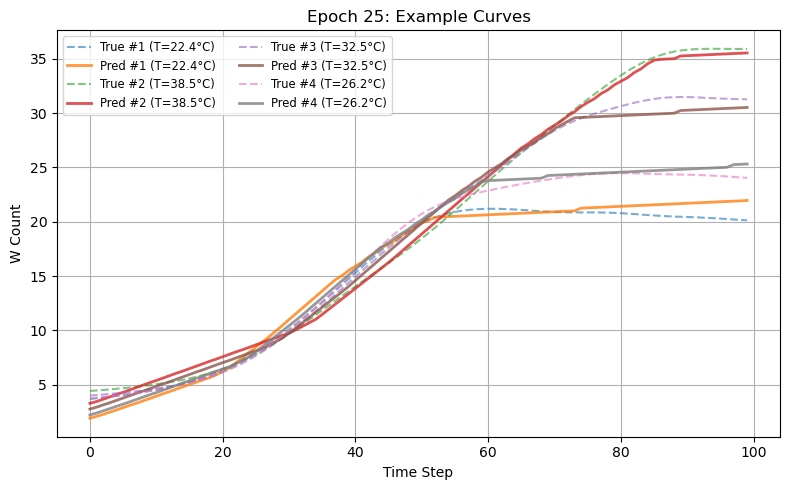

Epoch  26 | Train Loss: 0.393560 | Val Loss: 0.363269
Epoch  27 | Train Loss: 0.339432 | Val Loss: 0.312178
Epoch  28 | Train Loss: 0.304677 | Val Loss: 0.266341
Epoch  29 | Train Loss: 0.264129 | Val Loss: 0.244448
Epoch  30 | Train Loss: 0.244977 | Val Loss: 0.230898
Epoch  31 | Train Loss: 0.244829 | Val Loss: 0.216761
Epoch  32 | Train Loss: 0.234988 | Val Loss: 0.234141
Epoch  33 | Train Loss: 0.225716 | Val Loss: 0.203505
Epoch  34 | Train Loss: 0.218235 | Val Loss: 0.212474
Epoch  35 | Train Loss: 0.219932 | Val Loss: 0.198980
Epoch  36 | Train Loss: 0.212881 | Val Loss: 0.194455
Epoch  37 | Train Loss: 0.212031 | Val Loss: 0.186213
Epoch  38 | Train Loss: 0.209155 | Val Loss: 0.184245
Epoch  39 | Train Loss: 0.214301 | Val Loss: 0.187046
Epoch  40 | Train Loss: 0.231000 | Val Loss: 0.179155
Epoch  41 | Train Loss: 0.212155 | Val Loss: 0.189563
Epoch  42 | Train Loss: 0.215759 | Val Loss: 0.210188
Epoch  43 | Train Loss: 0.213498 | Val Loss: 0.279436
Epoch  44 | Train Loss: 0.23

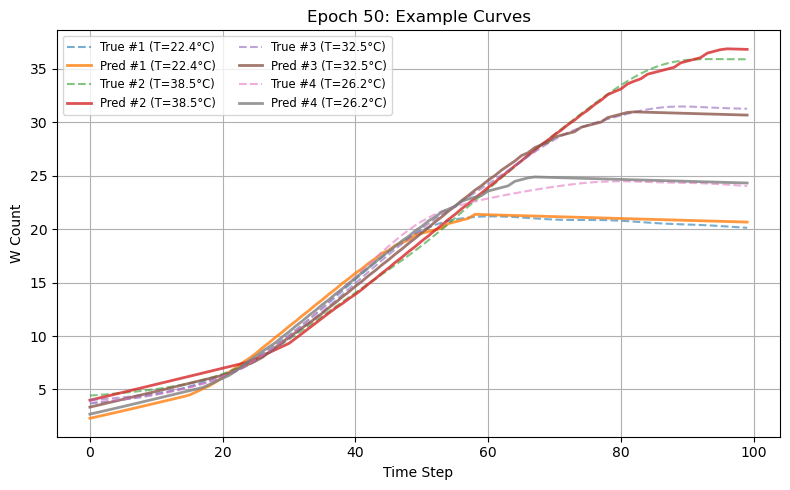

Epoch  51 | Train Loss: 0.179718 | Val Loss: 0.162411
Epoch  52 | Train Loss: 0.185241 | Val Loss: 0.191808
Epoch  53 | Train Loss: 0.179114 | Val Loss: 0.170173
Epoch  54 | Train Loss: 0.181185 | Val Loss: 0.155680
Epoch  55 | Train Loss: 0.174019 | Val Loss: 0.159747
Epoch  56 | Train Loss: 0.186666 | Val Loss: 0.157690
Epoch  57 | Train Loss: 0.187814 | Val Loss: 0.288444
Epoch  58 | Train Loss: 0.220319 | Val Loss: 0.151236
Epoch  59 | Train Loss: 0.187713 | Val Loss: 0.164298
Epoch  60 | Train Loss: 0.187575 | Val Loss: 0.192050
Epoch  61 | Train Loss: 0.196339 | Val Loss: 0.173241
Epoch  62 | Train Loss: 0.209057 | Val Loss: 0.250850
Epoch  63 | Train Loss: 0.181696 | Val Loss: 0.168699
Epoch  64 | Train Loss: 0.177477 | Val Loss: 0.161871
Epoch  65 | Train Loss: 0.167787 | Val Loss: 0.172893
Epoch  66 | Train Loss: 0.168707 | Val Loss: 0.171131
Epoch  67 | Train Loss: 0.187793 | Val Loss: 0.177196
Epoch  68 | Train Loss: 0.177427 | Val Loss: 0.192727
No improvement for 10 epochs

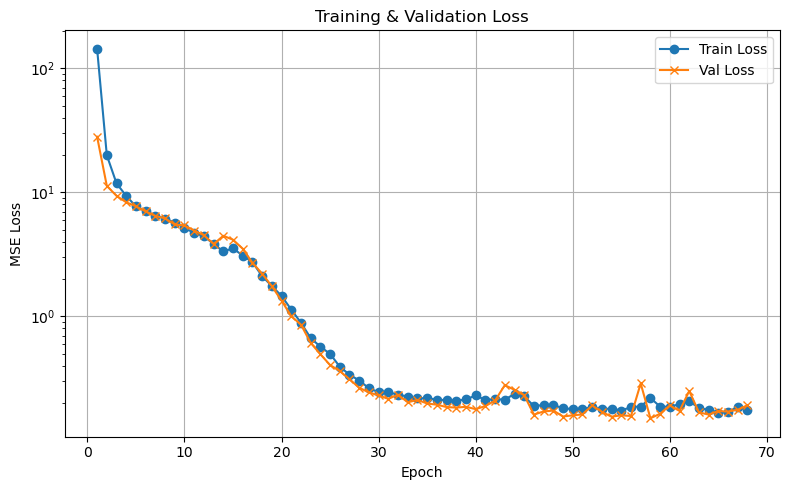

0.15123649934927622

In [5]:

# ─── Training Configuration ──────────────────────────────────────────
    
epochs = 100
batch_size = 8
learning_rate = 1e-2

output_model_path = "decision_net.pth"

validation_split = 0.2
patience = 10
curve_interval = 25
num_example_curves = 4

    # 4) Train
trainer = Trainer(
    decision_net=decision_net,
    simulator=sim,
    dataset=dataset,
    device=device,
    num_epochs=epochs,
    batch_size=batch_size,
    lr=learning_rate,
    validation_split=validation_split,
    patience=patience,
    visualize=True,
    curve_interval=curve_interval,
    num_example_curves=num_example_curves,
    output_model_path=output_model_path
)
trainer.train()


In [6]:
# test 

model_path = "decision_net.pth"
decision_net.load_state_dict(torch.load(model_path, map_location=device))

env_test = Environment(25)
sim.T_max = 60
sim.run(env_test,"train",3, output = "out/")



=== Starting simulation - Mode: train ===
[t=0] Phase 1 (Sense)
[t=0] Phase 2 (Evolve): applying dynamics to all agents.
    Node 0 (S): {'age': 0.0, 'size': 1.1}
    Node 1 (L): {'age': 0.0, 'size': 0.2}
    Node 2 (L): {'age': 0.0, 'size': 0.2}
    Node 3 (SAM): {'age': 0.0}
[t=0] Phase 3 (Think)
[t=0] Phase 4 (Act)


C:\Users\leobr\AppData\Local\Temp\ipykernel_9248\669228694.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  n_to_spawn = int(torch.ceil(torch.tensor(delta)).item())


[t=1] Phase 1 (Sense)
[t=1] Phase 2 (Evolve): applying dynamics to all agents.
    Node 0 (S): {'age': 0.0, 'size': 1.2000000000000002}
    Node 1 (L): {'age': 0.0, 'size': 0.30000000000000004}
    Node 2 (L): {'age': 0.0, 'size': 0.30000000000000004}
    Node 3 (SAM): {'age': 0.0}
    Node 4 (S): {'age': 0.0, 'size': 1.1}
    Node 5 (L): {'age': 0.0, 'size': 0.2}
    Node 6 (L): {'age': 0.0, 'size': 0.2}
    Node 7 (S): {'age': 0.0, 'size': 1.1}
    Node 8 (L): {'age': 0.0, 'size': 0.2}
    Node 9 (L): {'age': 0.0, 'size': 0.2}
[t=1] Phase 3 (Think)
[t=1] Phase 4 (Act)
[t=2] Phase 1 (Sense)
[t=2] Phase 2 (Evolve): applying dynamics to all agents.
    Node 0 (S): {'age': 0.0, 'size': 1.3000000000000003}
    Node 1 (L): {'age': 0.0, 'size': 0.4}
    Node 2 (L): {'age': 0.0, 'size': 0.4}
    Node 3 (SAM): {'age': 0.0}
    Node 4 (S): {'age': 0.0, 'size': 1.2000000000000002}
    Node 5 (L): {'age': 0.0, 'size': 0.30000000000000004}
    Node 6 (L): {'age': 0.0, 'size': 0.30000000000000004}

tensor([ 2.6193,  2.7493,  2.8807,  3.0132,  3.1464,  3.2806,  3.4155,  3.5509,
         3.6870,  3.8235,  3.9604,  4.0977,  4.2352,  4.3731,  4.5113,  4.6496,
         4.8639,  5.1417,  5.4217,  5.7004,  5.9793,  6.4097,  6.8845,  7.3016,
         7.7631,  8.1718,  8.6334,  9.0683,  9.5893, 10.0571, 10.5855, 11.0599,
        11.5883, 12.0627, 12.5911, 13.0655, 13.5940, 14.0683, 14.5968, 15.0711,
        15.5996, 16.0732, 16.5992, 17.0714, 17.5853, 18.0060, 18.5179, 18.9386,
        19.3594, 19.8713, 20.1355, 20.6127, 20.8636, 21.1145, 21.5866, 21.7428,
        21.8990, 22.0552, 22.4761, 22.6323], grad_fn=<CatBackward0>)